# データセットを作成し学習する データ拡張を行う
## 【問題1】自作データセットでの分類の学習

In [1]:
#VGG１６のロード、分類機は含めない
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
conv_base.trainable = False


Using TensorFlow backend.


In [135]:
#ベースに全結合分類機を追加
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
#model.add(layers.Dropout(0.2))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [136]:
train_dir = "/Users/morio/diveintocode-ml/sprint19/訓練データ"
validation_dir = "/Users/morio/diveintocode-ml/sprint19/val"

In [137]:
#凍結された畳み込みベースを使ってモデル全体を訓練
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, #ターゲットディレクトリ
    target_size=(150,150),
    batch_size=19,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
     validation_dir, #テストディレクトリ
     target_size=(150,150),
     batch_size=4,
     class_mode='binary')

model.compile(loss='binary_crossentropy',
                        optimizer=optimizers.RMSprop(lr=2e-5),
                        metrics=['acc'])
                 
history = model.fit_generator(train_generator,
                                                    steps_per_epoch=10,
                                                    epochs=10,
                                                    validation_data=validation_generator,
                                                    validation_steps=1,
                                                    verbose=2)

Found 19 images belonging to 2 classes.
Found 4 images belonging to 2 classes.
Epoch 1/10
 - 49s - loss: 0.4154 - acc: 0.9105 - val_loss: 0.3177 - val_acc: 1.0000
Epoch 2/10
 - 46s - loss: 0.2168 - acc: 1.0000 - val_loss: 0.1983 - val_acc: 1.0000
Epoch 3/10
 - 46s - loss: 0.1349 - acc: 1.0000 - val_loss: 0.1277 - val_acc: 1.0000
Epoch 4/10
 - 47s - loss: 0.0883 - acc: 1.0000 - val_loss: 0.0874 - val_acc: 1.0000
Epoch 5/10
 - 43s - loss: 0.0587 - acc: 1.0000 - val_loss: 0.0594 - val_acc: 1.0000
Epoch 6/10
 - 43s - loss: 0.0396 - acc: 1.0000 - val_loss: 0.0409 - val_acc: 1.0000
Epoch 7/10
 - 45s - loss: 0.0269 - acc: 1.0000 - val_loss: 0.0283 - val_acc: 1.0000
Epoch 8/10
 - 45s - loss: 0.0184 - acc: 1.0000 - val_loss: 0.0196 - val_acc: 1.0000
Epoch 9/10
 - 43s - loss: 0.0125 - acc: 1.0000 - val_loss: 0.0137 - val_acc: 1.0000
Epoch 10/10
 - 42s - loss: 0.0085 - acc: 1.0000 - val_loss: 0.0095 - val_acc: 1.0000


## 【問題2】分類データセットに対するデータ拡張
diverのやつ　https://github.com/albu/albumentations

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

### imageDataGeneratorを使って生成された画像を見てみる

In [94]:
# 画像ファイルをPIL形式でオープン
img_path = "/Users/morio/diveintocode-ml/sprint19/訓練データ/duck/IMG_2731.JPG"
img = image.load_img(img_path, target_size=(150,150))
# PIL形式をnumpyのndarray形式に変換
x = image.img_to_array(img)
# (height, width, 3) -> (1, height, width, 3)
x = x.reshape((1,) + x.shape)

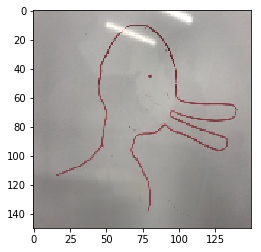

In [95]:
#元画像
plt.imshow(x[0]/255.)

In [50]:
def show_imgs(imgs, row, col):
    """Show PILimages as row*col
     # Arguments
            imgs: 1-D array, include PILimages
            row: Int, row for plt.subplot
            col: Int, column for plt.subplot
    """
    if len(imgs) != (row * col):
        raise ValueError("Invalid imgs len:{} col:{} row:{}".format(len(imgs), row, col))
    
    #plt.figure(figsize=(30,20))
    for i, img in enumerate(imgs):
        plot_num = i+1
        plt.subplot(row, col, plot_num)
        plt.tick_params(labelbottom="off") # x軸の削除
        plt.tick_params(labelleft="off") # y軸の削除
        plt.imshow(img)
    plt.show()

In [90]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60, #画像をランダムに回転範囲
    width_shift_range=0.2, #ランダムに水平移動させる範囲　幅全体に対する割合
    height_shift_range=0.2, #ランダムに高さ移動させる範囲　高さ全体に対する割合
    shear_range=0.3, #等積変形をランダムに適用　斜めに引き延ばすような感じ
    zoom_range=0.3, #図形の内側をランダムにズーム
    channel_shift_range=60, #チャンネルをランダムに移動
    horizontal_flip=True, #画像の半分を水平方向にランダムに反転
    #vertical_flip=True, #画像の半分を垂直方向にランダムに反転
    fill_mode='nearest') #新たに作成されたピクセルの埋め方


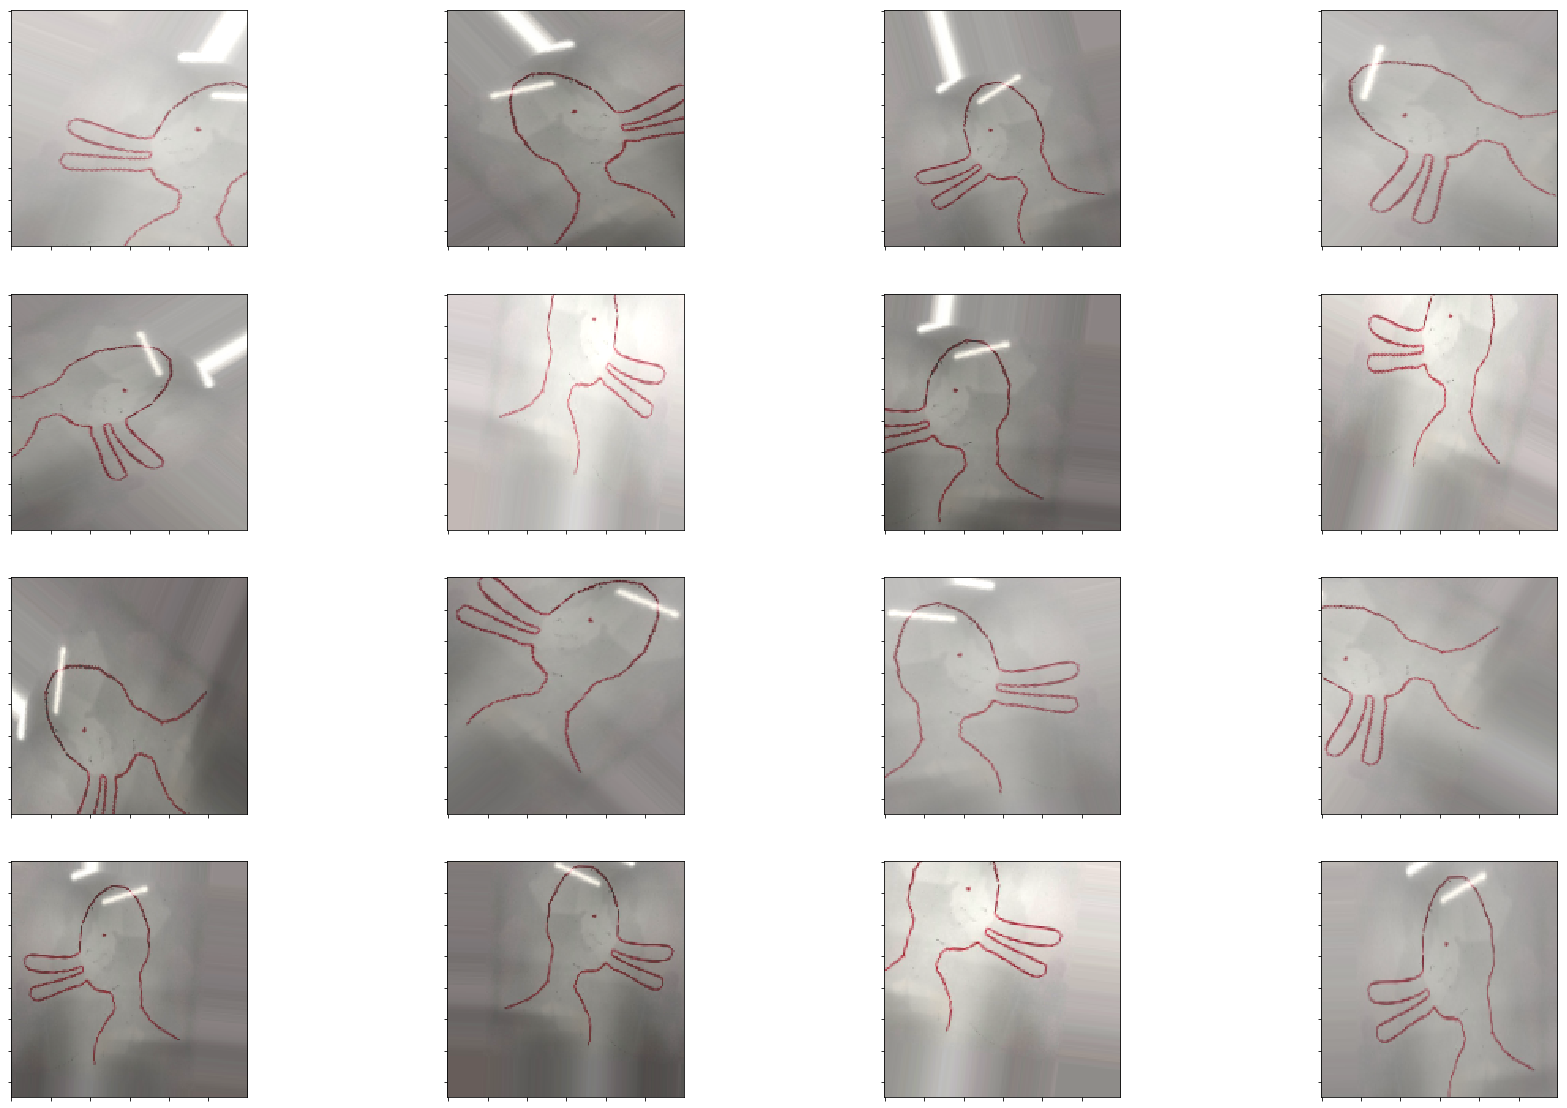

In [91]:
max_img_num = 16
imgs = []
for d in datagen.flow(x, batch_size=1):
    # このあと画像を表示するためにndarrayをPIL形式に変換して保存する
    imgs.append(image.array_to_img(d[0], scale=True))
    # datagen.flowは無限ループするため必要な枚数取得できたらループを抜ける
    if (len(imgs) % max_img_num) == 0:
        break
plt.figure(figsize=(30,20))
show_imgs(imgs, row=4, col=4)

### 水平、垂直、回転を使って水増しを行い学習する

In [141]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
#model.add(layers.Dropout(0.2))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [142]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20, #画像をランダムに回転範囲
    width_shift_range=0.2, #ランダムに水平移動させる範囲　幅全体に対する割合
    height_shift_range=0.2, #ランダムに高さ移動させる範囲　高さ全体に対する割合
    #shear_range=0.3, #等積変形をランダムに適用　斜めに引き延ばすような感じ
    #zoom_range=0.3, #図形の内側をランダムにズーム
    #channel_shift_range=60, #チャンネルをランダムに移動
    #horizontal_flip=True, #画像の半分を水平方向にランダムに反転
    #vertical_flip=True, #画像の半分を垂直方向にランダムに反転
    fill_mode='nearest') #新たに作成されたピクセルの埋め方


test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, #ターゲットディレクトリ
    target_size=(150,150),
    batch_size=19,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
     validation_dir, #テストディレクトリ
     target_size=(150,150),
     batch_size=4,
     class_mode='binary')

model.compile(loss='binary_crossentropy',
                        optimizer=optimizers.RMSprop(lr=2e-5),
                        metrics=['acc'])
                 
history = model.fit_generator(train_generator,
                                                    steps_per_epoch=10,
                                                    epochs=10,
                                                    validation_data=validation_generator,
                                                    validation_steps=1,
                                                    verbose=2)

Found 19 images belonging to 2 classes.
Found 4 images belonging to 2 classes.
Epoch 1/10
 - 44s - loss: 0.5818 - acc: 0.6526 - val_loss: 0.3952 - val_acc: 1.0000
Epoch 2/10
 - 41s - loss: 0.4354 - acc: 0.8895 - val_loss: 0.2935 - val_acc: 1.0000
Epoch 3/10
 - 40s - loss: 0.3401 - acc: 0.9474 - val_loss: 0.2208 - val_acc: 1.0000
Epoch 4/10
 - 43s - loss: 0.2941 - acc: 0.9579 - val_loss: 0.1867 - val_acc: 1.0000
Epoch 5/10
 - 43s - loss: 0.2490 - acc: 0.9684 - val_loss: 0.1517 - val_acc: 1.0000
Epoch 6/10
 - 42s - loss: 0.2154 - acc: 0.9842 - val_loss: 0.1177 - val_acc: 1.0000
Epoch 7/10
 - 42s - loss: 0.1981 - acc: 0.9842 - val_loss: 0.1089 - val_acc: 1.0000
Epoch 8/10
 - 42s - loss: 0.1718 - acc: 0.9737 - val_loss: 0.0761 - val_acc: 1.0000
Epoch 9/10
 - 42s - loss: 0.1283 - acc: 0.9895 - val_loss: 0.0573 - val_acc: 1.0000
Epoch 10/10
 - 42s - loss: 0.1278 - acc: 0.9842 - val_loss: 0.0540 - val_acc: 1.0000


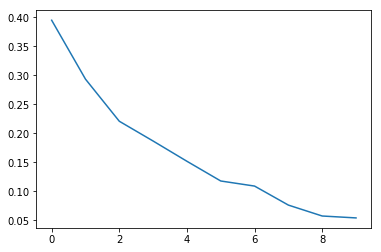

In [143]:
plt.plot(history.history["val_loss"])

### その他色々使って水増しを行い学習する

In [160]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
#model.add(layers.Dropout(0.2))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [206]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    #rotation_range=60, #画像をランダムに回転範囲
    width_shift_range=0.2, #ランダムに水平移動させる範囲　幅全体に対する割合
    height_shift_range=0.2, #ランダムに高さ移動させる範囲　高さ全体に対する割合
    #shear_range=0.3, #等積変形をランダムに適用　斜めに引き延ばすような感じ
    #zoom_range=0.3, #図形の内側をランダムにズーム
    channel_shift_range=60, #チャンネルをランダムに移動
    horizontal_flip=True, #画像の半分を水平方向にランダムに反転
    #vertical_flip=True, #画像の半分を垂直方向にランダムに反転
    fill_mode='nearest') #新たに作成されたピクセルの埋め方


test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, #ターゲットディレクトリ
    target_size=(150,150),
    batch_size=19,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
     validation_dir, #テストディレクトリ
     target_size=(150,150),
     batch_size=4,
     class_mode='binary')

model.compile(loss='binary_crossentropy',
                        optimizer=optimizers.RMSprop(lr=2e-5),
                        metrics=['acc'])
                 
history = model.fit_generator(train_generator,
                                                    steps_per_epoch=10,
                                                    epochs=10,
                                                    validation_data=validation_generator,
                                                    validation_steps=1,
                                                    verbose=2)

Found 19 images belonging to 2 classes.
Found 4 images belonging to 2 classes.
Epoch 1/10
 - 47s - loss: 0.2839 - acc: 0.8737 - val_loss: 0.0100 - val_acc: 1.0000
Epoch 2/10
 - 45s - loss: 0.2794 - acc: 0.8895 - val_loss: 0.0121 - val_acc: 1.0000
Epoch 3/10
 - 46s - loss: 0.1990 - acc: 0.9579 - val_loss: 0.0153 - val_acc: 1.0000
Epoch 4/10
 - 47s - loss: 0.1952 - acc: 0.9263 - val_loss: 0.0101 - val_acc: 1.0000
Epoch 5/10
 - 47s - loss: 0.1728 - acc: 0.9579 - val_loss: 0.0096 - val_acc: 1.0000
Epoch 6/10
 - 44s - loss: 0.1567 - acc: 0.9632 - val_loss: 0.0105 - val_acc: 1.0000
Epoch 7/10
 - 46s - loss: 0.1398 - acc: 0.9632 - val_loss: 0.0076 - val_acc: 1.0000
Epoch 8/10
 - 44s - loss: 0.1245 - acc: 0.9895 - val_loss: 0.0073 - val_acc: 1.0000
Epoch 9/10
 - 44s - loss: 0.1217 - acc: 0.9737 - val_loss: 0.0096 - val_acc: 1.0000
Epoch 10/10
 - 43s - loss: 0.0997 - acc: 1.0000 - val_loss: 0.0066 - val_acc: 1.0000


水増しなし　 loss: 0.0085 - acc: 1.0000 - val_loss: 0.0095 - val_acc: 1.0000

水平、垂直、回転                                     loss: 0.1278 - acc: 0.9842 - val_loss: 0.0540 - val_acc: 1.0000

等積変形、ズーム、チャンネル移動、反転　 loss: 0.1622 - acc: 0.9895 - val_loss: 0.1412 - val_acc: 1.0000

等積変形  loss: 0.0074 - acc: 1.0000 - val_loss: 0.0094 - val_acc: 1.0000

ズーム　 loss: 0.0312 - acc: 1.0000 - val_loss: 0.0195 - val_acc: 1.0000

チャンネル移動   loss: 0.0113 - acc: 1.0000 - val_loss: 0.0093 - val_acc: 1.0000

水平反転   loss: 0.0274 - acc: 1.0000 - val_loss: 0.0319 - val_acc: 1.0000

垂直反転　 loss: 0.0331 - acc: 1.0000 - val_loss: 0.0295 - val_acc: 1.0000

### 結果としては組み合わせるとlossが高いので組み合わせて使いすぎるとあんまり良くないかもしれません、等積変形、チャンネル移動がよかった。今回の場合回転させると違うクラスの見た目になるので回転はあまり使わない方がよさそう。

In [187]:
test_dir = "/Users/morio/diveintocode-ml/sprint19/test/"
#test = test_generator.next()
#pred = model.predict_generator(test[0])

In [183]:
import os
test_list = os.listdir(test_dir)

In [185]:
test_list.remove('.DS_Store',)

/Users/morio/.pyenv/versions/anaconda3-5.3.0/envs/python-ml/lib/python3.6/site-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


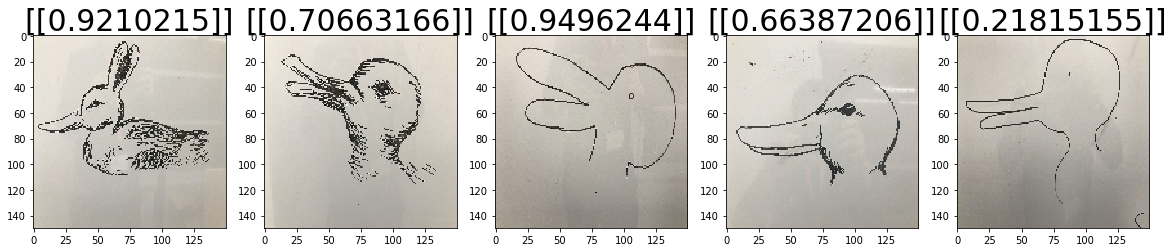

In [210]:
plt.figure(figsize=(20,10))
for i,img in enumerate(test_list):
    img_pass = os.path.join(test_dir, img)
    x = image.load_img(img_pass, target_size=(150,150))
    x = image.img_to_array(x) /255.
    x = x.reshape(1, 150 ,150, 3)
    pred = model.predict(x)
    plt.subplot(1,5, i+1)
    plt.title(pred, fontdict={'fontsize':30})
    plt.imshow(x[0])

個人的には左からあひる、うさぎ、うさぎ、あひる、あひる　に見えます。

ラベル１がうさぎなので正解は3/5

In [205]:
train_generator.class_indices

{'duck': 0, 'rabbit': 1}

# 【問題4】物体検出データセットの用意
アノテーションツール　https://github.com/tzutalin/labelImg

yolo v3 keras で試しました。

アノテーションファイルを作成します

In [423]:
write_pass = "/Users/morio/diveintocode-ml/sprint18/keras-yolo3/train.txt"
path = "/Users/morio/diveintocode-ml/sprint18/keras-yolo3/訓練データ/duck"

In [424]:
paths = os.listdir(path)

In [425]:
texts = [t for t in paths if "xml" in t]

In [426]:
images = [m for m in paths if "JPG" in m] 

In [427]:
images

['IMG_2729.JPG',
 'IMG_2727.JPG',
 'IMG_2731.JPG',
 'IMG_2742.JPG',
 'IMG_2741.JPG',
 'IMG_2740.JPG',
 'IMG_2747.JPG']

In [428]:
texts

['IMG_2729.xml',
 'IMG_2727.xml',
 'IMG_2731.xml',
 'IMG_2742.xml',
 'IMG_2741.xml',
 'IMG_2740.xml',
 'IMG_2747.xml']

In [420]:
class_dict = {"duck": 0, "rabbit": 1}
anote_list = []

In [429]:
import xml.etree.ElementTree as ET 

for t, m in zip(texts, images):
    xml_pass = os.path.join(path, t)
    img_pass = os.path.join(path, m)
    # XMLファイルを解析
    tree = ET.parse(xml_pass) 
    # XMLを取得
    xml = tree.getroot()
    xmin = xml[6][4][0].text
    ymin = xml[6][4][1].text
    xmax = xml[6][4][2].text
    ymax = xml[6][4][3].text
    clas = str(class_dict[xml[6][0].text])
    text = img_pass + " "  + xmin + "," + ymin + "," + xmax + "," + ymax + "," + clas
    anote_list += [text]

In [430]:
anote_list

['/Users/morio/diveintocode-ml/sprint18/keras-yolo3/訓練データ/rabbit/IMG_2748.JPG 84,4,640,287,1',
 '/Users/morio/diveintocode-ml/sprint18/keras-yolo3/訓練データ/rabbit/IMG_2739.JPG 37,171,640,459,1',
 '/Users/morio/diveintocode-ml/sprint18/keras-yolo3/訓練データ/rabbit/IMG_2735.JPG 95,19,346,480,1',
 '/Users/morio/diveintocode-ml/sprint18/keras-yolo3/訓練データ/rabbit/IMG_2734.JPG 84,1,352,480,1',
 '/Users/morio/diveintocode-ml/sprint18/keras-yolo3/訓練データ/rabbit/IMG_2736.JPG 219,15,483,468,1',
 '/Users/morio/diveintocode-ml/sprint18/keras-yolo3/訓練データ/rabbit/IMG_2737.JPG 20,108,639,443,1',
 '/Users/morio/diveintocode-ml/sprint18/keras-yolo3/訓練データ/rabbit/IMG_2733.JPG 36,119,640,287,1',
 '/Users/morio/diveintocode-ml/sprint18/keras-yolo3/訓練データ/rabbit/IMG_2732.JPG 1,125,639,404,1',
 '/Users/morio/diveintocode-ml/sprint18/keras-yolo3/訓練データ/rabbit/IMG_2726.JPG 29,4,640,314,1',
 '/Users/morio/diveintocode-ml/sprint18/keras-yolo3/訓練データ/rabbit/IMG_2730.JPG 5,111,640,320,1',
 '/Users/morio/diveintocode-ml/sprint18

In [431]:
 #書き出し
str_ = '\n'.join(anote_list)
with open(write_pass, 'wt') as f:
    f.write(str_)

学習と推定

50エポックほど学習させましたが、うまく行きませんでした。学習が足りないのか、データの座標指定が何かおかしいのか

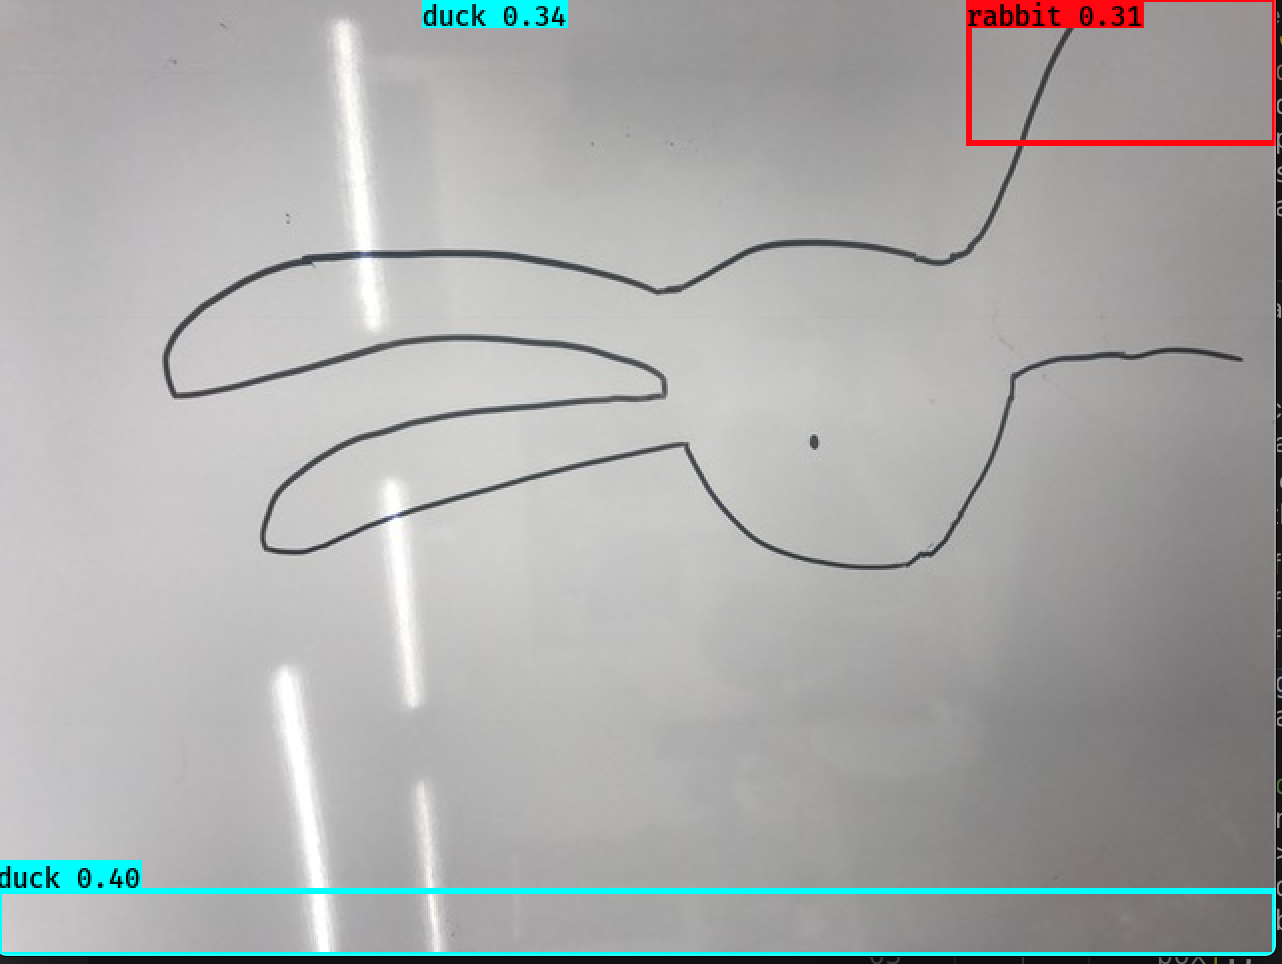

In [432]:
from IPython.display import Image, display_png
display_png(Image("2019-03-17 13.48.46.png"))

## 【問題6】物体検出データセットに対するデータ拡張
albumentationsでやる

In [462]:
%matplotlib inline
from urllib.request import urlopen
import os

import numpy as np
import cv2
from matplotlib import pyplot as plt

from albumentations import (
    HorizontalFlip,
    VerticalFlip,
    Resize,
    CenterCrop,
    RandomCrop,
    Crop,
    Compose
)

In [463]:
def download_image(url):
    data = urlopen(url).read()
    data = np.frombuffer(data, np.uint8)
    image = cv2.imdecode(data, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [464]:
# Functions to visualize bounding boxes and class labels on an image. 
# Based on https://github.com/facebookresearch/Detectron/blob/master/detectron/utils/vis.py

BOX_COLOR = (255, 0, 0)
TEXT_COLOR = (255, 255, 255)


def visualize_bbox(img, bbox, class_id, class_idx_to_name, color=BOX_COLOR, thickness=2):
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    class_name = class_idx_to_name[class_id]
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(img, class_name, (x_min, y_min - int(0.3 * text_height)), cv2.FONT_HERSHEY_SIMPLEX, 0.35,TEXT_COLOR, lineType=cv2.LINE_AA)
    return img


def visualize(annotations, category_id_to_name):
    img = annotations['image'].copy()
    for idx, bbox in enumerate(annotations['bboxes']):
        img = visualize_bbox(img, bbox, annotations['category_id'][idx], category_id_to_name)
    plt.figure(figsize=(12, 12))
    plt.imshow(img)

In [465]:
def get_aug(aug, min_area=0., min_visibility=0.):
    return Compose(aug, bbox_params={'format': 'coco', 'min_area': min_area, 'min_visibility': min_visibility, 'label_fields': ['category_id']})

In [466]:
image = download_image('http://images.cocodataset.org/train2017/000000386298.jpg')

In [467]:
# Annotations for image 386298 from COCO http://cocodataset.org/#explore?id=386298
annotations = {'image': image, 'bboxes': [[366.7, 80.84, 132.8, 181.84], [5.66, 138.95, 147.09, 164.88]], 'category_id': [18, 17]}
category_id_to_name = {17: 'cat', 18: 'dog'}

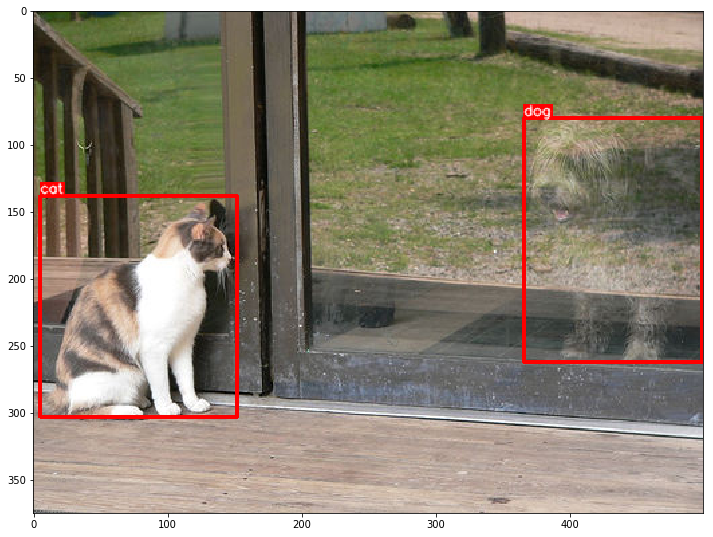

In [468]:
visualize(annotations, category_id_to_name)

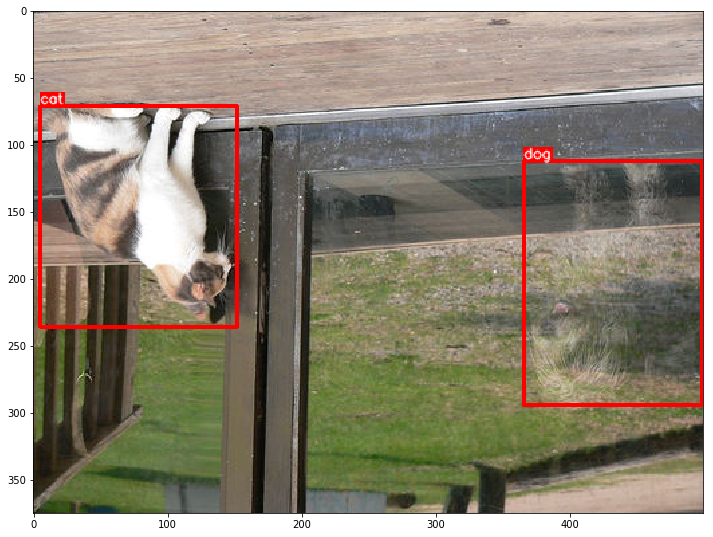

In [469]:
aug = get_aug([VerticalFlip(p=1)])
augmented = aug(**annotations)
visualize(augmented, category_id_to_name)

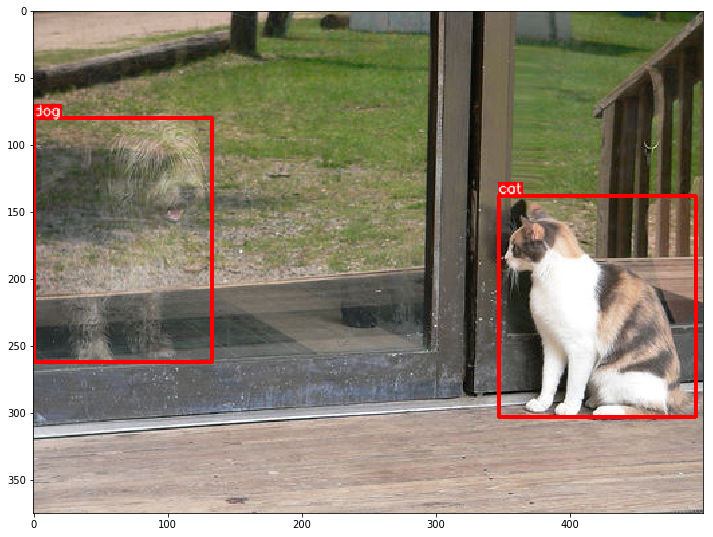

In [470]:
aug = get_aug([HorizontalFlip(p=1)])
augmented = aug(**annotations)
visualize(augmented, category_id_to_name)

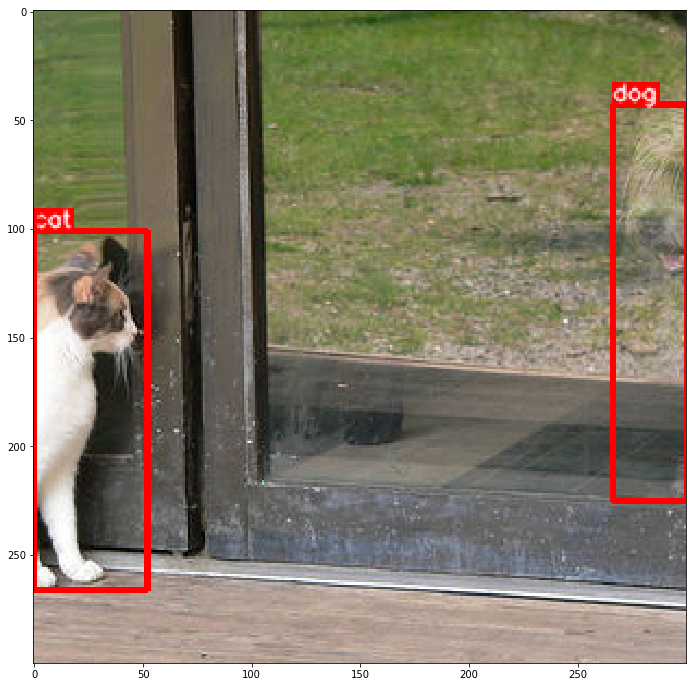

In [471]:
aug = get_aug([CenterCrop(p=1, height=300, width=300)])
augmented = aug(**annotations)
visualize(augmented, category_id_to_name)